In [1]:
from pathlib import Path

import numpy as np
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI
from jaxpower import (compute_mesh_power, PowerSpectrumMultipoles, generate_gaussian_mesh, generate_anisotropic_gaussian_mesh, generate_uniform_particles, RealMeshField, ParticleField, FKPField,
                      compute_fkp_power, BinnedStatistic, WindowMatrix, MeshAttrs, BinAttrs, compute_mean_mesh_power, compute_mesh_window, compute_normalization, utils, create_sharding_mesh, make_particles_from_local, create_sharded_array, create_sharded_random, compute_fkp_normalization_and_shotnoise)

attrs = MeshAttrs(meshsize=(128,) * 3, boxsize=1000., boxcenter=1200.)
size = int(1e-4 * attrs.boxsize.prod())
data = generate_uniform_particles(attrs, size + 1, seed=42)
randoms = generate_uniform_particles(attrs, 4 * size + 1, seed=43)

cosmo = DESI()
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)

f, b = 0.8, 1.5
beta = f / b
kinedges = np.linspace(0.001, 0.7, 100)
kin = (kinedges[:-1] + kinedges[1:]) / 2.
ells = (0, 2, 4)
poles = jnp.array([(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pk(kin),
                    0.9 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pk(kin),
                    8. / 35 * beta ** 2 * pk(kin)])
theory = BinnedStatistic(x=[kin] * len(ells), edges=[kinedges] * len(ells), value=poles, projs=ells)
mesh = generate_anisotropic_gaussian_mesh(attrs, theory, seed=random.key(42), los='local', unitary_amplitude=True)
data = data.clone(weights=1. + mesh.read(data.positions))

In [2]:
fkp = FKPField(data, randoms, **attrs.clone(boxsize=2. * attrs.boxsize))  # x2 padding
norm, shotnoise_nonorm = compute_fkp_normalization_and_shotnoise(fkp)
#mesh = fkp.paint(resampler='tsc', interlacing=0, compensate=False, out='real')
mesh = fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
print(mesh.attrs)
poles = compute_mesh_power(mesh, edges={'step': 0.01}, ells=(0, 2, 4), los='firstpoint').clone(norm=norm, shotnoise_nonorm=shotnoise_nonorm)

MeshAttrs(meshsize=staticarray([128, 128, 128], dtype=int32), boxsize=staticarray([2000., 2000., 2000.]), boxcenter=staticarray([1200., 1200., 1200.]), dtype=dtype('float64'), fft_engine='jaxdecomp')


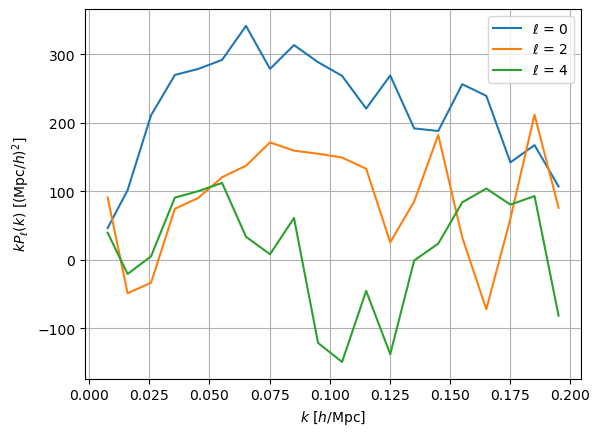

In [3]:
poles.plot(show=True);

In [4]:
import itertools
list_poles = {}
edges = {'step': 0.01}
nsubboxes = 2

for level, nsubbox in enumerate([1, nsubboxes]):
    # nsubbox: number of subboxes per dimension
    list_poles[level] = []
    # iterate over subboxes
    for isub in itertools.product(*(range(n) for n in [nsubbox] * attrs.ndim)):
        offset = attrs.boxcenter - attrs.boxsize / 2.
        subboxsize = attrs.boxsize / nsubbox
        isub = np.array(isub)
    
        def get_subbox_particles(particles):
            mask = np.all((particles.positions >= isub * subboxsize + offset) & (particles.positions <= (isub + 1) * subboxsize + offset), axis=1)
            return particles.clone(positions=particles.positions[mask], weights=particles.weights[mask])

        # FKP field = data - randoms
        fkp = FKPField(get_subbox_particles(data), get_subbox_particles(randoms), boxsize=2 * subboxsize,
                       boxcenter=(isub + 0.5) * subboxsize + offset,
                       meshsize=attrs.meshsize // nsubboxes)
        # We could compute the normalization only once (or sum up the subbox normalizations);
        # same about shotnoise
        norm_subbox, shotnoise_nonorm_subbox = compute_fkp_normalization_and_shotnoise(fkp)
        # Paint field to mesh
        mesh = fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
        print(level, mesh.attrs)
        # Compute mesh power spectrum
        poles_subbox = compute_mesh_power(mesh, edges=edges, ells=(0, 2, 4), los='firstpoint').clone(norm=norm_subbox, shotnoise_nonorm=shotnoise_nonorm_subbox)
        list_poles[level].append(poles_subbox)

0 MeshAttrs(meshsize=staticarray([64, 64, 64], dtype=int32), boxsize=staticarray([2000., 2000., 2000.]), boxcenter=staticarray([1200., 1200., 1200.]), dtype=dtype('float64'), fft_engine='jaxdecomp')
1 MeshAttrs(meshsize=staticarray([64, 64, 64], dtype=int32), boxsize=staticarray([1000., 1000., 1000.]), boxcenter=staticarray([950., 950., 950.]), dtype=dtype('float64'), fft_engine='jaxdecomp')
1 MeshAttrs(meshsize=staticarray([64, 64, 64], dtype=int32), boxsize=staticarray([1000., 1000., 1000.]), boxcenter=staticarray([ 950.,  950., 1450.]), dtype=dtype('float64'), fft_engine='jaxdecomp')
1 MeshAttrs(meshsize=staticarray([64, 64, 64], dtype=int32), boxsize=staticarray([1000., 1000., 1000.]), boxcenter=staticarray([ 950., 1450.,  950.]), dtype=dtype('float64'), fft_engine='jaxdecomp')
1 MeshAttrs(meshsize=staticarray([64, 64, 64], dtype=int32), boxsize=staticarray([1000., 1000., 1000.]), boxcenter=staticarray([ 950., 1450., 1450.]), dtype=dtype('float64'), fft_engine='jaxdecomp')
1 MeshAt

In [5]:
def combine_multigrid_power(list_power, fnyq=0.8):
    # Stack multigrid power spectra

    def get_slices(list_xedges):
        list_slices, list_nmodes, list_x, list_edges = [], [], [], []
        last_edge = 0.
        for i, (nmodes, x, edges) in enumerate(list_xedges):
            final = i == len(list_xedges) - 1
            mask = edges >= last_edge
            mask &= edges <= (1.1 if final else fnyq) * edges[-1]
            idx = np.flatnonzero(mask)
            sl = slice(idx[0], idx[-1], 1)
            list_slices.append(sl)
            list_nmodes.append(nmodes[sl])
            list_x.append(x[sl])
            list_edges.append(edges[sl.start:sl.stop + final])
            last_edge = edges[idx[-1]]
        return list_slices, np.concatenate(list_nmodes), np.concatenate(list_x), np.concatenate(list_edges)

    list_slices, nmodes, x, edges = get_slices([(list_power[level][0].nmodes(projs=0), list_power[level][0].x(projs=0), list_power[level][0].edges(projs=0)) for level in list_power])
    power_nonorm = []
    for level in list_power:
        sl = list_slices[level]
        # summing subbox (unnormalized) power spectra together
        power_nonorm.append(sum(jnp.stack(power._value)[..., sl] for power in list_power[level]))
    power_nonorm = np.concatenate(power_nonorm, axis=-1)
    power = list_power[0][0]
    ells, norm, shotnoise_nonorm = power._projs, power._norm, power._shotnoise_nonorm
    return PowerSpectrumMultipoles(x, power_nonorm=power_nonorm, nmodes=nmodes, edges=edges, ells=ells,
                                   norm=norm, shotnoise_nonorm=shotnoise_nonorm, power_zero_nonorm=power._power_zero_nonorm)

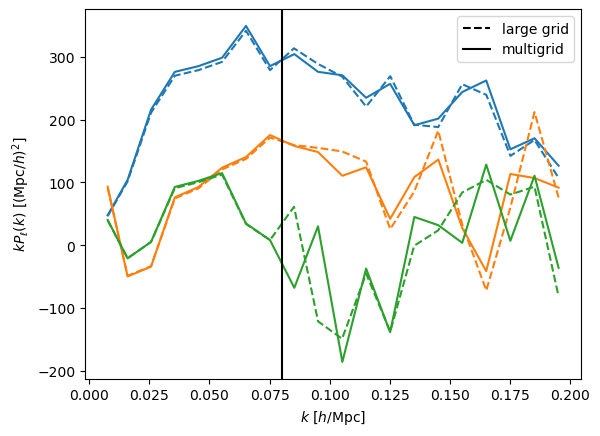

In [6]:
fnyq = 0.8
poles_multigrid = combine_multigrid_power(list_poles, fnyq=fnyq)
ax = plt.gca()
for iproj, proj in enumerate(poles_multigrid.projs):
    color = 'C{:d}'.format(iproj)
    k = poles.x(projs=proj)
    ax.plot(k, k * poles.view(projs=proj).real, linestyle='--', color=color)
    k = poles_multigrid.x(projs=proj)
    ax.plot(k, k * poles_multigrid.view(projs=proj).real, linestyle='-', color=color)
ax.plot([], [], color='k', linestyle='--', label='large grid')
ax.plot([], [], color='k', linestyle='-', label='multigrid')
ax.axvline(x=list_poles[0][0].edges(projs=0)[-1] * fnyq, color='k')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend()
plt.show()